In [27]:
import matplotlib.pyplot as plt
import numpy as np

This notebook implements the Perfect Lens from "Ray-tracing model of a perfect lens compliant
with Fermat’s principle: the Cardinal Lens", and correctly calculate ray positions in the image plane for the case of magnification less than 1.0 including for magnification less than 1e-10, and for magnifcation greater than 1.0, up to but not including the case where magnification > 1e10.

In [28]:
def calculate_direction_cosines(x0, y0, z0, x1, y1, z1):
    # Calculate the principal ray vector from ray coordinate on object to centre of lens
    vx = x0 - x1
    vy = y0 - y1
    vz = z0 - z1
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # And it's direction cosines
    M = vy / v_mag 
    L = vx / v_mag
    N = vz / v_mag
    
    return L, M, N

Main Perfect lens function here: The one part I have a question about is what exactly does this sentence mean in Section 3.B of the paper:

" We then internally set the paraxial magnification
so that it equals z2/z1 and, for the infinite front conjugate case,
temporarily modify the incoming ray direction cosines to make
them consistent with the finite long-conjugate approximation "

I am unsure how to temporarily modify the incoming direction cosines, I have instead worked out that one can set a new position for the incoming principal ray if magnification is less than 1e-10, and it seems to give the same answer. 

See lines 19-21 in the cell below, and lines 36 and 37, which modify the L2_p and M2_p direction based on the location of the principal ray. 

In [29]:
def perfect_lens(x1, y1, z1, L1, M1, N1, z2, m_p):
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    mdx = mdy = m_p
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        
        # If magnification is less than 1e-10, use infinite front cojugate plane approximation
        if np.abs(m_p) <= 1e-10:
            z1 = -1e10
            m_p = z2 / z1
            
            # Unsure about this, but I need to set new principal ray location
            # to get the calculation to work. 
            principal_plane_x = u1
            principal_plane_y = v1
            L1_p, M1_p, N1_p = L1, M1, N1
        else:
            
            # Otherwise, principal ray just goes through centre of lens
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0)
            
        # Obtain coordinates in image plane relative to principal ray direction
        x2 = z2 * L1_p / N1_p
        y2 = z2 * M1_p / N1_p
    
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L2_p = (x2 - principal_plane_x)  / rp
        M2_p = (y2 - principal_plane_y) / rp
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        if np.abs(m_p) >= 1e10:
            raise(NotImplementedError)
        else:
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
        
        a = x1 / z1
        b = y1 / z1
        N2_p = np.sqrt(1 - a ** 2 - b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2

    # Calculate Cx and Cy using GSC
    Cx = (mdx * L2_p) - L1_p
    Cy = (mdy * M2_p) - M1_p

    # Obtain direction cosines of ray leaving the second principal plane
    L2 = (L1 + Cx) / mdx
    M2 = (M1 + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    # Find location of ray in second principal plane
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
    
    return x2, y2, u1, v1, u2, v2
    

Perfect Lens: Infinite Front Conjugate Case

In [30]:
# initialise lens parameters
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

# Magnification is less than 1e-10, so we want rays to focus to a point on the 
# back focal plane
m_p = 1e-11
f = 5

# Set z1 and z2 to focal plane for plotting clarity if magnification is too small. 
if np.abs(m_p) < 1e-10:
    z1 = f * (-1)  
    z2 = f * (1)
else:
    z1 = f * ((1 / m_p)  -1)
    z2 = f * (1 - m_p)

N = 10

# Define x and y coordinates of rat starting positions
x1 = np.linspace(-0.0, 0.0, N)
y1 = np.linspace(0, 5, N)
z1 = np.linspace(-5, -5, N)

angles = np.linspace(0.5, 0.5, N) #Radians

L1 = np.zeros(N) # x direction cosine
M1 = np.sin(angles) # y direction cosine
N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2) #z direction cosine

# Calculate coordinates for perfect lens
x2, y2, u1, v1, u2, v2 = perfect_lens(x1, y1, z1, L1, M1, N1, z2, m_p)

Plot results

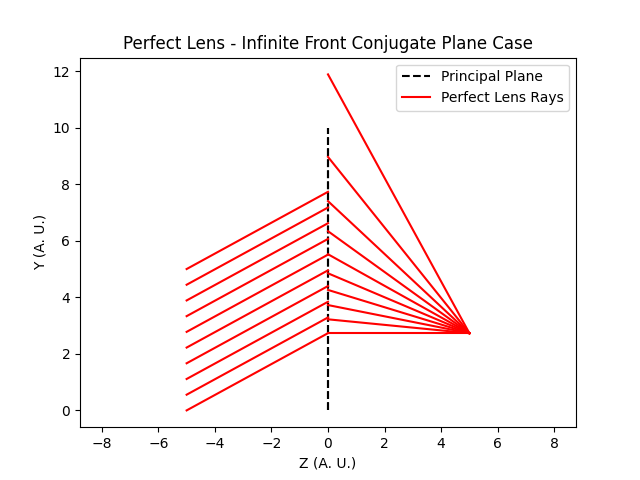

In [31]:
plt.figure()
plt.vlines(pp_1, 0, 10, linestyle = '--', color = 'k', label = 'Principal Plane')
plt.vlines(pp_2,  0, 10, linestyle = '--', color = 'k')

# Make array of coordinates for plotting
pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

plt.plot([z1 + pp_1s, pp_1s], [y1, v1], '-r')
plt.plot([], [], '-r', label = 'Perfect Lens Rays')
plt.xlabel('Z (A. U.)')
plt.ylabel('Y (A. U.)')
plt.title('Perfect Lens - Infinite Front Conjugate Plane Case')
plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-r')
plt.axis('equal')
plt.legend()


Perhaps the best thing to do is this much simpler version of the fourier lens, where we basically just use simple sin and tan operations to achieve the same behaviour? It will be faster to calculate. 